In [26]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict,\
    StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix, \
    classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict,\
    StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_val_predict

from sklearn.preprocessing import StandardScaler

import warnings

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

**Dataset Description:**
We are provided hourly rental data spanning two years.

**Task:**
We should predict bike rental count hourly based on the environmental and seasonal settings.

**Dataset Attributes:**
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [27]:
df = pd.read_csv('hour.csv', sep=',')

In [28]:
df[:5]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [29]:
df['year'] = pd.to_datetime(df['dteday']).dt.year
df['month'] = pd.to_datetime(df['dteday']).dt.month
df['day'] = pd.to_datetime(df['dteday']).dt.day

In [30]:
df = df.drop(['instant', 'dteday', 'yr', 'mnth'], 1)

In [31]:
df.shape

(17379, 16)

In [32]:
df[:5]

,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day
0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011,1,1
1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011,1,1
2,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011,1,1
3,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011,1,1
4,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011,1,1


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   hr          17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   weekday     17379 non-null  int64  
 4   workingday  17379 non-null  int64  
 5   weathersit  17379 non-null  int64  
 6   temp        17379 non-null  float64
 7   atemp       17379 non-null  float64
 8   hum         17379 non-null  float64
 9   windspeed   17379 non-null  float64
 10  casual      17379 non-null  int64  
 11  registered  17379 non-null  int64  
 12  cnt         17379 non-null  int64  
 13  year        17379 non-null  int64  
 14  month       17379 non-null  int64  
 15  day         17379 non-null  int64  
dtypes: float64(4), int64(12)
memory usage: 2.1 MB


In [34]:
df.describe()

,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088,2011.502561,6.537775,15.683411
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599,0.500008,3.438776,8.789373
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,2011.000000,4.000000,8.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,2012.000000,7.000000,16.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,2012.000000,10.000000,23.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,2012.000000,12.000000,31.000000


In [35]:
df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.987672,-0.069881,-0.023125,0.404772
atemp,0.987672,1.000000,-0.051918,-0.062336,0.400929
hum,-0.069881,-0.051918,1.000000,-0.290105,-0.322911
windspeed,-0.023125,-0.062336,-0.290105,1.000000,0.093234
cnt,0.404772,0.400929,-0.322911,0.093234,1.000000


temp and atemp are highly correlated that can affect our result.

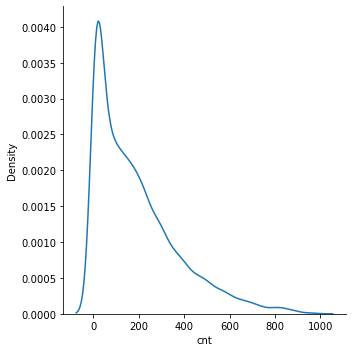

In [36]:
sns.displot(df['cnt'], kind='kde');

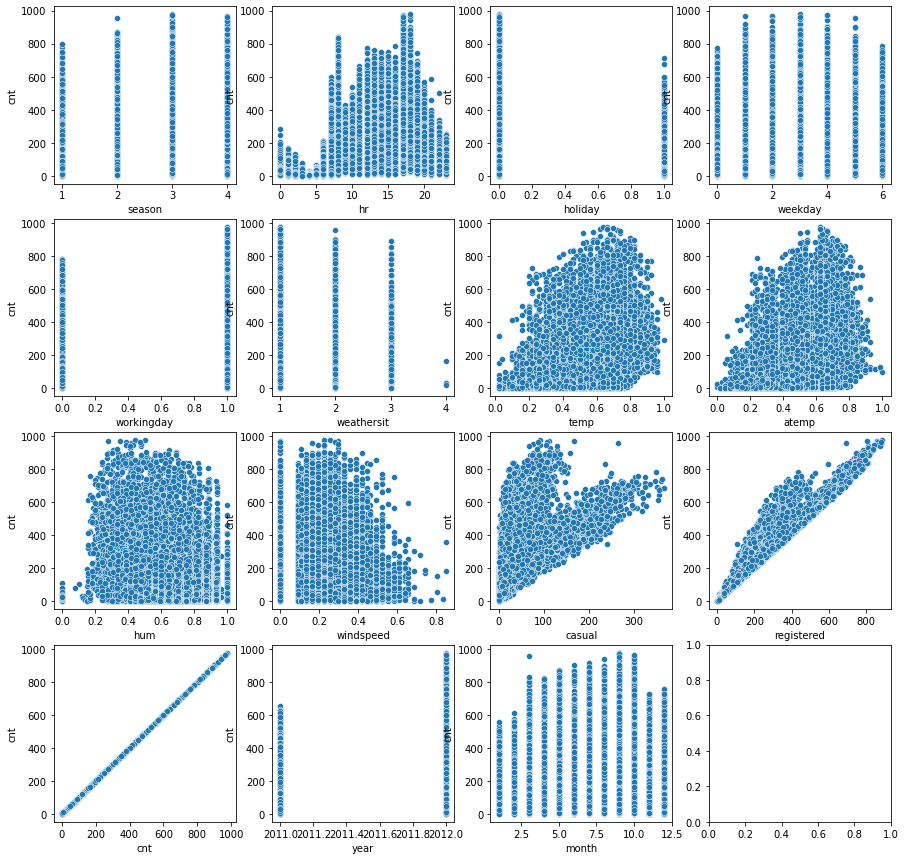

In [37]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for idx, feature in enumerate(df.columns[:-1]):
    sns.scatterplot(data = df, x=df.columns[idx], y='cnt', ax=axes[idx//4, idx%4])

In [38]:
X = df[df.columns[0:-1]]
y = df['cnt']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=10)

st = StandardScaler()
X_train_std = st.fit_transform(X_train)

st = StandardScaler()
X_test_std = st.fit_transform(X_test)

In [39]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))*100

**Creation of Gradient Descent Class**

In [40]:
class GD(object):
    def __init__(self, lr=1e-3, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def _init_params(self):
        self.weights = np.zeros(self.n_features)
        self.bias = 0

    def _update_params(self, dw, db):
        self.weights -= self.lr * dw
        self.bias -= self.lr * db
        
    def get_gradients(self, X, y, y_pred):
        error = y_pred-y
        dw = (1 / self.n_samples) * np.dot(X.T, error)
        db = (1 / self.n_samples) * np.sum(error)
        return dw, db

    def predict(self, X):
        y_pred = np.dot(X, self.weights) + self.bias
        return y_pred

    def fit(self, X, y):
        self.n_samples, self.n_features = X.shape
        self._init_params()

        for _ in range(self.n_iters):
            y_pred = self.predict(X)
            dw, db = self.get_gradients(X, y, y_pred)
            self._update_params(dw, db)

**Creation of Stochastic Gradient Descent Class**

In [41]:
class SGD(object):
    def __init__(self, lr=1e-3, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def _init_params(self):
        self.weights = np.zeros(self.n_features)
        self.bias = 0

    def _update_params(self, dw, db):
        self.weights -= self.lr * dw
        self.bias -= self.lr * db
        
    def get_gradients(self, X, y, y_pred):
        error = y_pred-y
        dw = (1 / self.n_samples) * np.dot(X.T, error)
        db = (1 / self.n_samples) * np.sum(error)
        return dw, db

    def predict(self, X):
        y_pred = np.dot(X, self.weights) + self.bias
        return y_pred
    
    def fit(self, X, y):
        for _ in range(self.n_iters):
            index = np.random.randint(0, len(X), X.shape[1])
            X_rand = np.take(X, index)
            y_rand = np.take(y, index)
            
            self.n_samples = 1
            self.n_features = X_rand.shape
            self._init_params()

            y_pred = self.predict(X_rand)
            dw, db = self.get_gradients(X_rand, y_rand, y_pred)
            self._update_params(dw, db)

**Predictions**

In [42]:
def evaluation(y_test, y_pred):
    print(y_pred)
    print('---------')
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('MAPE %:', mape(y_test, y_pred)*100)
    print('MSE:', mean_squared_error(y_test, y_pred))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('---------')

In [43]:
LR = LinearRegression()
LR.fit(X_train_std, y_train)
y_pred = LR.predict(X_test_std)
evaluation(y_test, y_pred)
for tuple_in_list in zip(df.columns, LR.coef_):
    print(tuple_in_list)

[380.02571222 128.28307361  24.87437762 ...   6.57338203 362.09801977
 179.63953443]
---------
MAE: 3.3857544744885275
MAPE %: 381.7402174389736
MSE: 19.26468994173461
RMSE: 4.389155948668788
---------
('season', -6.5534099731761245e-15)
('hr', -1.3018916161243851e-14)
('holiday', -2.6536520655462073e-14)
('weekday', 5.3274867413378055e-15)
('workingday', 7.813097219861457e-15)
('weathersit', 3.424610604863389e-15)
('temp', -4.399354934871654e-14)
('atemp', -8.798444785035197e-15)
('hum', -7.682448307231033e-15)
('windspeed', -5.279037947009372e-14)
('casual', 28.04280268799179)
('registered', 85.77841363973906)
('cnt', 79.1994955982192)
('year', 2.5575670543257153e-14)
('month', 3.941430339711342e-14)


In [47]:
Grad = GD()
Grad.fit(X_train_std, y_train)
y_pred = Grad.predict(X_test_std)
evaluation(y_test, y_pred)

[288.88765128  54.33897303 -16.13294084 ... -45.70165771 302.75425122
 121.00629487]
---------
MAE: 66.62896668074488
MAPE %: 30748.114796300295
MSE: 5399.079752523766
RMSE: 73.4784305257248
---------


In [48]:
StochGrad = SGD()
StochGrad.fit(X_train_std, y_train)
y_pred = StochGrad.predict(X_test_std)
evaluation(y_test, y_pred)

[4.18012413 3.2201582  2.81415809 ... 2.56211244 4.57184229 3.46342616]
---------
MAE: 183.93311386229217
MAPE %: 9293.95877762578
MSE: 65647.8678663459
RMSE: 256.2183987662594
---------
